In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\asus\OneDrive\EV-projects\evcs-projects")
SCRIPTS_DIR = PROJECT_ROOT / "scripts"

sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(SCRIPTS_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SCRIPTS_DIR :", SCRIPTS_DIR)

import destruction_reconstruction
print("Imported from:", destruction_reconstruction.__file__)


PROJECT_ROOT: C:\Users\asus\OneDrive\EV-projects\evcs-projects
SCRIPTS_DIR : C:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts
Imported from: C:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts\destruction_reconstruction.py


PROJECT_ROOT: C:\Users\asus\OneDrive\EV-projects\evcs-projects
SCRIPTS_DIR : C:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts
Imported destruction_reconstruction from: C:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts\destruction_reconstruction.py
Loaded instance: C:\Users\asus\OneDrive\EV-projects\evcs-projects\data\instances\inst_N20_seed1.json
Defaults: P= 4 Q= 15.0 D= 3.5
out keys: ['policy', 'score_exact', 'time_exact', 'optimal_exact', 'score_greedy', 'score_LS', 'time_LS', 'score_DR', 'DR_log', 'compare_exact_vs_best', 'm_exact', 'm_best']
score_exact: 59.99999999999999
score_LS   : 55.343494174008896
score_DR   : 55.343494174008896
Saved DR log: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\DR_log_N20_seed1_closest_only.csv


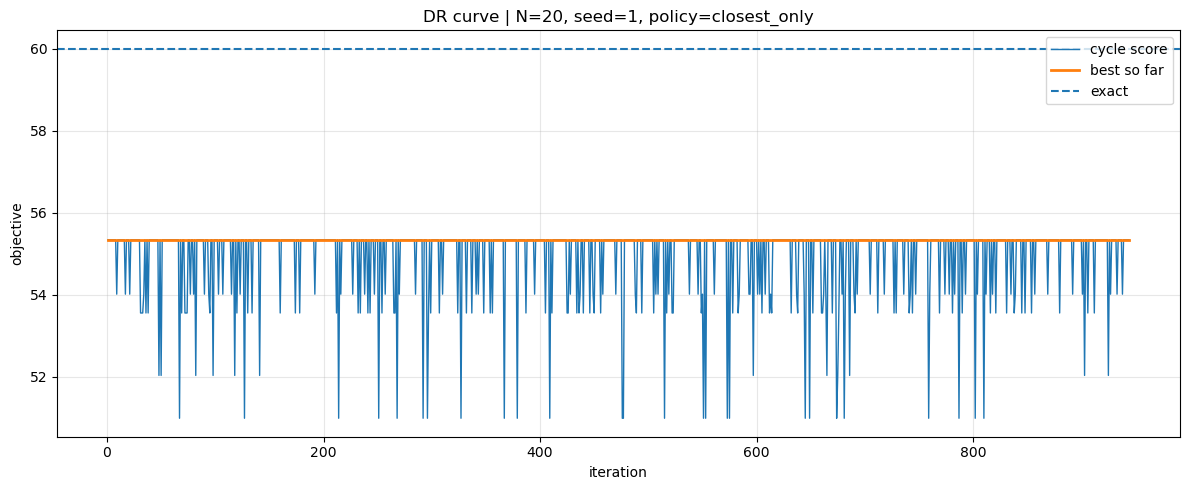

Saved DR curve: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\DR_curve_N20_seed1_closest_only.png
compare_exact_vs_best: {'n_open_A': 4, 'n_open_B': 4, 'only_A': [2, 4, 6], 'only_B': [12, 13, 14], 'common': [19]}
Saved compare dict: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\compare_exact_vs_best_N20_seed1_closest_only.csv
Exact exists: True
Best exists : True


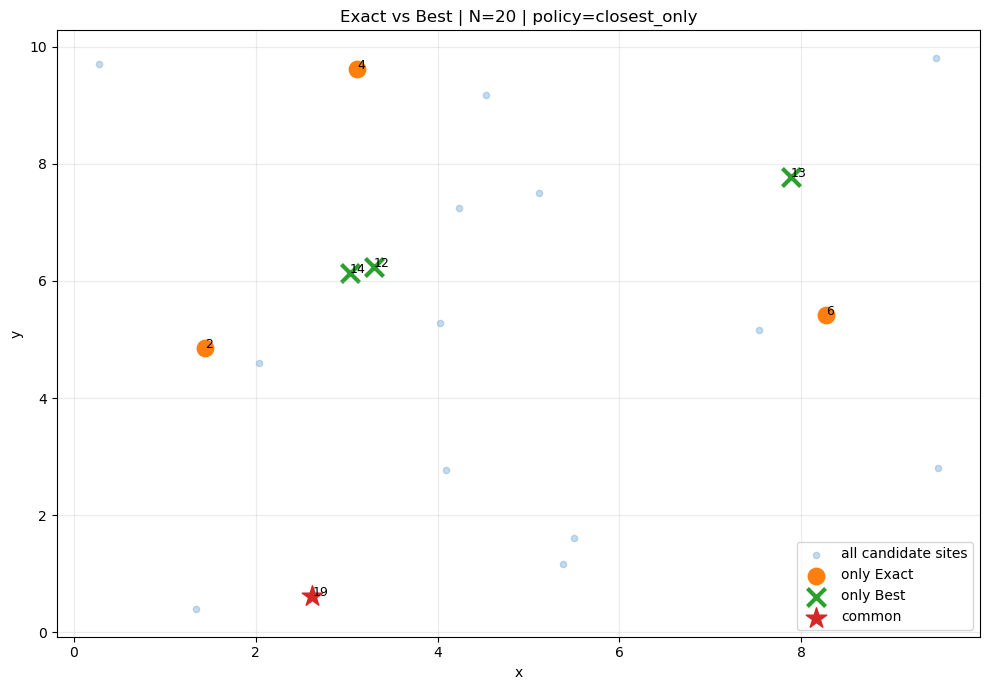

,station,status,load_exact,load_best,load_diff_best_minus_exact
0,19,common,15.0,14.173105,-0.826895
1,2,only_exact,15.0,0.000000,-15.000000
2,4,only_exact,15.0,0.000000,-15.000000
3,6,only_exact,15.0,0.000000,-15.000000
4,14,only_best,0.0,14.088342,14.088342
5,12,only_best,0.0,14.055498,14.055498
6,13,only_best,0.0,13.026550,13.026550


Saved load comparison table: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\load_compare_N20_seed1_closest_only.csv


In [3]:
# ============================================================
# 0) PATH FIX (FIRST CELL) - makes imports work
# ============================================================
import sys
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\asus\OneDrive\EV-projects\evcs-projects")
SCRIPTS_DIR  = PROJECT_ROOT / "scripts"

sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(SCRIPTS_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SCRIPTS_DIR :", SCRIPTS_DIR)

import destruction_reconstruction
print("Imported destruction_reconstruction from:", destruction_reconstruction.__file__)


# ============================================================
# 1) IMPORTS
# ============================================================
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from destruction_reconstruction import (
    run_one_policy,
    run_batch_one_pass,
    default_parameters_for
)

from scripts.randomInstance import generate_instance, save_instance, load_instance


# ============================================================
# 2) HELPERS (PLOTS + LOAD TABLE) - NO algorithm duplication
# ============================================================
def _get_val(v):
    try:
        return float(v.value) if getattr(v, "value", None) is not None else 0.0
    except Exception:
        try:
            return float(v)
        except Exception:
            return 0.0

def open_sites(m, thr=0.5):
    return [j for j in m.x if _get_val(m.x[j]) > thr]

def station_loads(m, demand_I, thr_open=0.5):
    """
    load[j] = sum_i demand[i] * y[i,j]  (for open stations only)
    """
    opens = set(open_sites(m, thr=thr_open))
    load = {j: 0.0 for j in opens}

    # m.Arcs is (i,j) for feasible arcs
    for (i, j) in m.Arcs:
        if j in load:
            load[j] += float(demand_I[i]) * _get_val(m.y[i, j])
    return load

def compare_load_table(m_exact, m_best, demand_I):
    """
    DataFrame on union of open stations:
      station | load_exact | load_best | status | diff
    """
    load_e = station_loads(m_exact, demand_I) if m_exact is not None else {}
    load_b = station_loads(m_best,  demand_I) if m_best  is not None else {}

    opens_e = set(load_e.keys())
    opens_b = set(load_b.keys())
    union = sorted(opens_e | opens_b)

    rows = []
    for j in union:
        status = "common" if (j in opens_e and j in opens_b) else ("only_exact" if j in opens_e else "only_best")
        rows.append({
            "station": j,
            "status": status,
            "load_exact": load_e.get(j, 0.0),
            "load_best":  load_b.get(j, 0.0),
        })

    df = pd.DataFrame(rows)
    df["load_diff_best_minus_exact"] = df["load_best"] - df["load_exact"]

    # Sort: common first, then only_exact, then only_best (or change if you prefer)
    order = {"common": 0, "only_exact": 1, "only_best": 2}
    df["_ord"] = df["status"].map(order)
    df = df.sort_values(by=["_ord", "load_exact", "load_best"], ascending=[True, False, False]).drop(columns=["_ord"])
    df = df.reset_index(drop=True)
    return df

def plot_open_sets(coords_J, open_exact, open_best, title="Exact vs Best open sites", annotate=True):
    """
    coords_J: list/array of (x,y) for candidate sites J (index=station id)
    open_exact/open_best: list of station indices
    """
    coords_J = np.asarray(coords_J)
    x_all, y_all = coords_J[:, 0], coords_J[:, 1]

    set_e = set(open_exact) if open_exact is not None else set()
    set_b = set(open_best)  if open_best  is not None else set()
    common = sorted(set_e & set_b)
    only_e = sorted(set_e - set_b)
    only_b = sorted(set_b - set_e)

    plt.figure(figsize=(10, 7))
    plt.scatter(x_all, y_all, s=20, alpha=0.25, label="all candidate sites")

    if only_e:
        plt.scatter(coords_J[only_e, 0], coords_J[only_e, 1], s=140, marker="o", label="only Exact")
    if only_b:
        plt.scatter(coords_J[only_b, 0], coords_J[only_b, 1], s=170, marker="x", linewidths=3, label="only Best")
    if common:
        plt.scatter(coords_J[common, 0], coords_J[common, 1], s=240, marker="*", label="common")

    if annotate:
        for j in sorted(set_e | set_b):
            plt.text(coords_J[j, 0], coords_J[j, 1], f"{j}", fontsize=9)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ============================================================
# 3) LOAD / GENERATE INSTANCE
# ============================================================
N = 20
seed = 1

inst_dir = str(PROJECT_ROOT / "data" / "instances")
os.makedirs(inst_dir, exist_ok=True)

inst_path = os.path.join(inst_dir, f"inst_N{N}_seed{seed}.json")

if os.path.exists(inst_path):
    inst = load_instance(inst_path)
    print("Loaded instance:", inst_path)
else:
    inst = generate_instance(N=N, seed=seed)
    save_instance(inst, inst_path)
    print("Generated+saved instance:", inst_path)

P, Q, D = default_parameters_for(N)
print("Defaults:", "P=", P, "Q=", Q, "D=", D)

policy = "closest_only"


# ============================================================
# 4) RUN ONE POLICY (Pipeline only; no duplication)
# ============================================================
out = run_one_policy(
    inst=inst,
    policy=policy,
    P=P, Q=Q, D=D,
    forbid_self=False,
    max_iter=50,
    dr_time_limit=300,
    dr_log_every=1,
    greedy_mode="W1",       # "deterministic" / "W1" / "W2"
    destroy_mode="area",    # "random"/"area"/"cluster"/"demand_low"/"demand_high"
    exact_time_limit=120,
    exact_mip_gap=0.02,
    allow_multi_charger=False,
    seed=seed
)

print("out keys:", list(out.keys()))
print("score_exact:", out.get("score_exact"))
print("score_LS   :", out.get("score_LS"))
print("score_DR   :", out.get("score_DR"))


# ============================================================
# 5) SAVE DR LOG + DR CURVE
# ============================================================
results_dir = str(PROJECT_ROOT / "results")
os.makedirs(results_dir, exist_ok=True)

dr_df = out["DR_log"]
dr_csv = os.path.join(results_dir, f"DR_log_N{N}_seed{seed}_{policy}.csv")
dr_df.to_csv(dr_csv, index=False)
print("Saved DR log:", dr_csv)

plt.figure(figsize=(12, 5))
plt.plot(dr_df["iteration"], dr_df["score"], label="cycle score", linewidth=1)
plt.plot(dr_df["iteration"], dr_df["best"],  label="best so far", linewidth=2)

score_exact = out.get("score_exact", np.nan)
if score_exact is not None and not np.isnan(score_exact):
    plt.axhline(score_exact, linestyle="--", label="exact")

plt.title(f"DR curve | N={N}, seed={seed}, policy={policy}")
plt.xlabel("iteration")
plt.ylabel("objective")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

dr_png = os.path.join(results_dir, f"DR_curve_N{N}_seed{seed}_{policy}.png")
plt.savefig(dr_png, dpi=180)
plt.show()
print("Saved DR curve:", dr_png)


# ============================================================
# 6) SAVE SIMPLE OPEN-SET COMPARISON DICT (already in out)
# ============================================================
cmp = out.get("compare_exact_vs_best", None)
print("compare_exact_vs_best:", cmp)

if cmp:
    cmp_csv = os.path.join(results_dir, f"compare_exact_vs_best_N{N}_seed{seed}_{policy}.csv")
    pd.DataFrame({"metric": list(cmp.keys()), "value": [str(v) for v in cmp.values()]}).to_csv(cmp_csv, index=False)
    print("Saved compare dict:", cmp_csv)


# ============================================================
# 7) MAP PLOT + LOAD COMPARISON TABLE (needs models)
# ============================================================
coords_J = inst["coords_J"]
demand_I = inst["demand_I"]

m_exact = out.get("m_exact", None)
m_best  = out.get("m_best", None)

print("Exact exists:", m_exact is not None)
print("Best exists :", m_best  is not None)

if (m_exact is None) or (m_best is None):
    print("\n⚠️ Your run_one_policy() is not returning m_exact/m_best.")
    print("To enable the map+load table, edit destruction_reconstruction.py and add at the end of run_one_policy():")
    print("   return {..., 'm_exact': m_exact, 'm_best': m_best}")
else:
    open_e = open_sites(m_exact)
    open_b = open_sites(m_best)

    plot_open_sets(
        coords_J,
        open_exact=open_e,
        open_best=open_b,
        title=f"Exact vs Best | N={len(coords_J)} | policy={out['policy']}",
        annotate=True
    )

    df_load = compare_load_table(m_exact, m_best, demand_I)
    display(df_load)

    load_csv = os.path.join(results_dir, f"load_compare_N{N}_seed{seed}_{policy}.csv")
    df_load.to_csv(load_csv, index=False)
    print("Saved load comparison table:", load_csv)



Running profiling... (short DR run)


,cumtime (s),cumtime (% of total),tottime (s),tottime (% of total),ncalls,function,location
0,61.588,100.000,0.005,0.008,1,run_one_policy,destruction_reconstruction.py:59
1,60.428,98.117,0.092,0.149,60,local_search,methods.py:346
2,48.676,79.035,3.154,5.121,31126,reassign_y,methods.py:359
3,27.063,43.943,6.574,10.673,16511859,__contains__,set.py:536
4,21.851,35.479,3.059,4.966,622520,<listcomp>,methods.py:365
5,16.618,26.983,1.026,1.665,4029035,value,var.py:197
6,15.593,25.318,5.596,9.086,4029167,set_value,var.py:134
7,13.171,21.386,4.204,6.826,12483044,get,set.py:1325
8,12.077,19.609,1.996,3.240,9718166,value,numeric_types.py:331
9,11.126,18.066,0.013,0.021,15699,objective,methods.py:383



=== Where time goes (grouped, based on tottime) ===


,group,tottime_s,tottime_%
0,other,39.024,63.36
1,membership checks,8.177,13.28
2,pyomo internals,5.737,9.32
3,your code (other),5.404,8.77
4,reassign_y,3.154,5.12
5,local_search,0.092,0.15


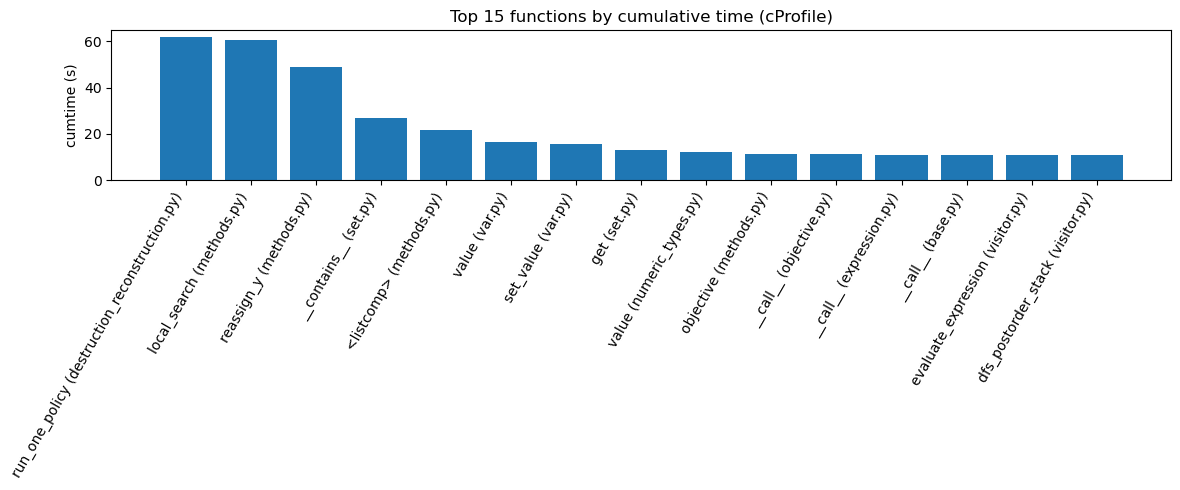

Saved: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\profile_top15_cumtime_N20_seed1_closest_only.png


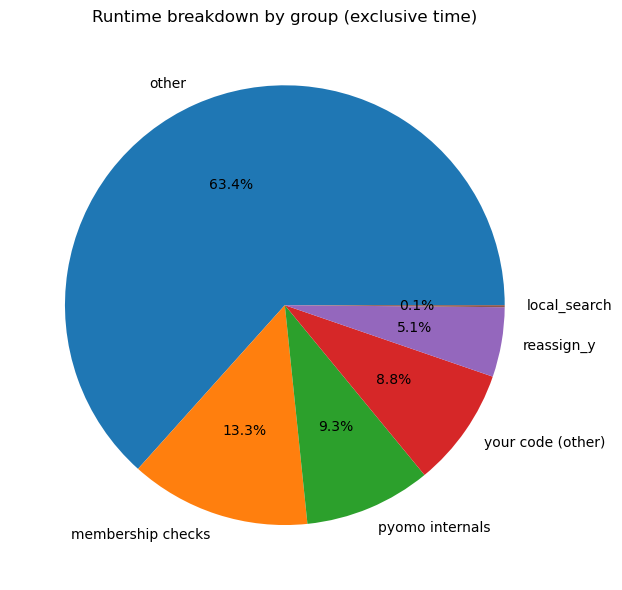

Saved: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\profile_group_pie_N20_seed1_closest_only.png
Saved: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\profile_full_N20_seed1_closest_only.csv
Saved: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\profile_table_top25_N20_seed1_closest_only.csv
Saved: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\profile_grouped_N20_seed1_closest_only.csv
Saved: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\profile_print_top60_N20_seed1_closest_only.txt

Headline:
  score_exact: 59.99999999999999
  score_LS   : 55.343494174008896
  score_DR   : 55.343494174008896


In [4]:
# ============================================================
# PROFILING CELL (run after your DR cell)
# ============================================================
import os, io, re
import cProfile, pstats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- settings (edit if you want) ----
PROFILE_DR_TIME = 60          # seconds for DR inside profiling run (keep short)
PROFILE_EXACT_TIME = 30       # exact solve time limit inside profiling run
PROFILE_TOPN_TABLE = 25       # rows in the table
PROFILE_TOPK_BAR = 15         # bars in the bar chart

# results_dir should already exist in your notebook; fall back if not
results_dir = globals().get("results_dir", "results")
os.makedirs(results_dir, exist_ok=True)

def _basename(path):
    try:
        return os.path.basename(str(path))
    except Exception:
        return str(path)

def profile_run_one_policy(**kwargs):
    pr = cProfile.Profile()
    pr.enable()
    out_prof = run_one_policy(**kwargs)
    pr.disable()
    return out_prof, pr

def pstats_to_df(pr: cProfile.Profile) -> pd.DataFrame:
    stats = pstats.Stats(pr)
    rows = []
    for (filename, lineno, funcname), (ccalls, ncalls, tottime, cumtime, callers) in stats.stats.items():
        rows.append({
            "filename": filename,
            "file": _basename(filename),
            "lineno": lineno,
            "function": funcname,
            "ncalls": ncalls,
            "tottime_s": float(tottime),
            "cumtime_s": float(cumtime),
        })
    df = pd.DataFrame(rows)
    df = df.sort_values("cumtime_s", ascending=False).reset_index(drop=True)
    total_tottime = df["tottime_s"].sum()
    df["tottime_%"] = (100.0 * df["tottime_s"] / total_tottime) if total_tottime > 0 else 0.0
    df["cumtime_%_vs_total_tottime"] = (100.0 * df["cumtime_s"] / total_tottime) if total_tottime > 0 else 0.0
    return df

def classify_group(row):
    fn = str(row["function"])
    file = str(row["file"]).lower()

    # Your key functions
    if fn == "local_search" or "local_search" in fn:
        return "local_search"
    if fn == "reassign_y" or "reassign_y" in fn:
        return "reassign_y"

    # Pyomo internal-ish buckets
    if ("pyomo" in file) or ("pyomo" in fn.lower()):
        return "pyomo internals"
    if fn in ("value",) and ("pyomo" in file):
        return "pyomo internals"
    if "set_value" in fn.lower() or "set_value" in file:
        return "pyomo internals"
    if "__contains__" in fn or "contains" in fn.lower():
        # often pyomo containers / set membership
        return "membership checks"

    # Your project files
    if file in ("destruction_reconstruction.py", "methods.py", "model.py"):
        return "your code (other)"

    return "other"

def make_presentation_table(df, topN=25):
    tbl = df.head(topN).copy()
    # compact filename
    tbl["location"] = tbl["file"].astype(str) + ":" + tbl["lineno"].astype(str)
    # nicer columns
    out = tbl[[
        "cumtime_s", "cumtime_%_vs_total_tottime",
        "tottime_s", "tottime_%",
        "ncalls", "function", "location"
    ]].copy()
    out.rename(columns={
        "cumtime_s": "cumtime (s)",
        "cumtime_%_vs_total_tottime": "cumtime (% of total)",
        "tottime_s": "tottime (s)",
        "tottime_%": "tottime (% of total)",
    }, inplace=True)
    # round
    for c in ["cumtime (s)", "tottime (s)", "cumtime (% of total)", "tottime (% of total)"]:
        out[c] = out[c].astype(float).round(3)
    out["ncalls"] = out["ncalls"].astype(int)
    return out

# ---- run profiling ----
print("Running profiling... (short DR run)")
out_prof, pr = profile_run_one_policy(
    inst=inst,
    policy=policy,
    P=P, Q=Q, D=D,
    forbid_self=False,
    max_iter=50,
    dr_time_limit=PROFILE_DR_TIME,
    dr_log_every=1,
    greedy_mode="W1",
    destroy_mode="area",
    exact_time_limit=PROFILE_EXACT_TIME,
    exact_mip_gap=0.05,
    allow_multi_charger=False,
    seed=seed
)

# ---- build stats table ----
df_prof = pstats_to_df(pr)

# presentation-friendly top table
table_df = make_presentation_table(df_prof, topN=PROFILE_TOPN_TABLE)
display(table_df)

# ---- grouped summary ("where time goes") ----
df_prof["group"] = df_prof.apply(classify_group, axis=1)

# Use tottime for grouping (exclusive time is best for "where CPU spent")
group_df = (df_prof.groupby("group", as_index=False)["tottime_s"]
            .sum()
            .sort_values("tottime_s", ascending=False)
            .reset_index(drop=True))
total_t = group_df["tottime_s"].sum()
group_df["tottime_%"] = (100.0 * group_df["tottime_s"] / total_t) if total_t > 0 else 0.0
group_df["tottime_s"] = group_df["tottime_s"].round(3)
group_df["tottime_%"] = group_df["tottime_%"].round(2)

print("\n=== Where time goes (grouped, based on tottime) ===")
display(group_df)

# ---- bar chart: top K by cumulative time ----
topk = df_prof.head(PROFILE_TOPK_BAR).copy()
labels = (topk["function"].astype(str) + " (" + topk["file"].astype(str) + ")")
plt.figure(figsize=(12, 5))
plt.bar(labels, topk["cumtime_s"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("cumtime (s)")
plt.title(f"Top {PROFILE_TOPK_BAR} functions by cumulative time (cProfile)")
plt.tight_layout()
bar_path = os.path.join(results_dir, f"profile_top{PROFILE_TOPK_BAR}_cumtime_N{N}_seed{seed}_{policy}.png")
plt.savefig(bar_path, dpi=180)
plt.show()
print("Saved:", bar_path)

# ---- pie chart: grouped tottime breakdown ----
plt.figure(figsize=(8, 6))
plt.pie(group_df["tottime_s"], labels=group_df["group"], autopct="%1.1f%%")
plt.title("Runtime breakdown by group (exclusive time)")
plt.tight_layout()
pie_path = os.path.join(results_dir, f"profile_group_pie_N{N}_seed{seed}_{policy}.png")
plt.savefig(pie_path, dpi=180)
plt.show()
print("Saved:", pie_path)

# ---- save CSVs + raw pstats text ----
full_csv = os.path.join(results_dir, f"profile_full_N{N}_seed{seed}_{policy}.csv")
table_csv = os.path.join(results_dir, f"profile_table_top{PROFILE_TOPN_TABLE}_N{N}_seed{seed}_{policy}.csv")
group_csv = os.path.join(results_dir, f"profile_grouped_N{N}_seed{seed}_{policy}.csv")

df_prof.to_csv(full_csv, index=False)
table_df.to_csv(table_csv, index=False)
group_df.to_csv(group_csv, index=False)

print("Saved:", full_csv)
print("Saved:", table_csv)
print("Saved:", group_csv)

# raw pstats printable text (nice to attach / send)
s = io.StringIO()
pstats.Stats(pr, stream=s).sort_stats(pstats.SortKey.CUMULATIVE).print_stats(60)
profile_txt = s.getvalue()
txt_path = os.path.join(results_dir, f"profile_print_top60_N{N}_seed{seed}_{policy}.txt")
with open(txt_path, "w", encoding="utf-8") as f:
    f.write(profile_txt)
print("Saved:", txt_path)

# quick headline numbers
print("\nHeadline:")
print("  score_exact:", out_prof.get("score_exact"))
print("  score_LS   :", out_prof.get("score_LS"))
print("  score_DR   :", out_prof.get("score_DR"))


SyntaxError: invalid syntax (761905540.py, line 1)